In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 18
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)
            
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])
#ax.set_xscale('log')

f gemessen, fehler 79.93990010982056 0.8207619854148238
phi gemessen, fehler 0.012509397667825592 0.00012843696392018356


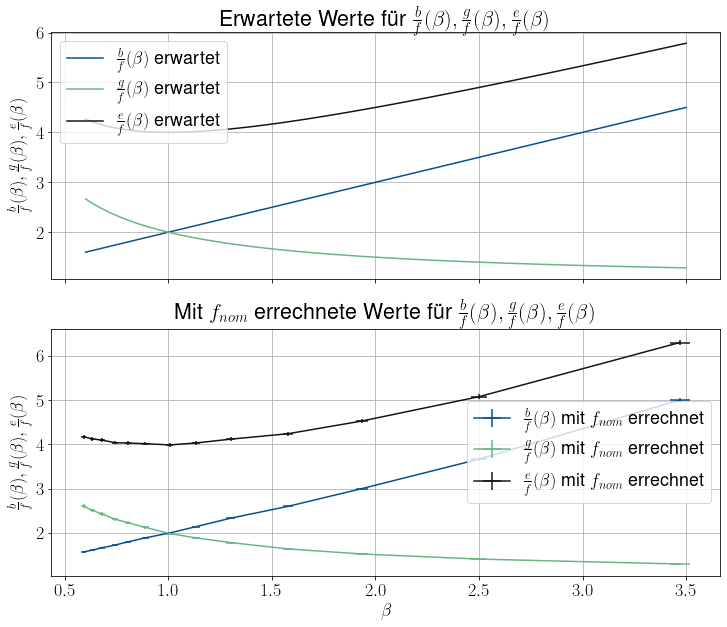

In [28]:
# Gemessene Werte Versuchteil 1
pos_dia = 200 #+- 1
e_gem_1 = np.array([647, 585, 552, 535, 522, 520, 521, 521, 525, 531, 536, 543, 550]) - pos_dia #sqrt(1^2+0.5^2)=sqrt(1.25)
g_gem_1 = np.array([300,310,320,330,340,350,360,370,380,390,400,410,420]) - pos_dia#<-- nice +-1
b_gem_1 = e_gem_1-g_gem_1

e_gem_1_f, g_gem_1_f = 2, 1
b_gem_1_f = np.sqrt(e_gem_1_f**2+g_gem_1_f**2) #Ich hab das mit der Formel gemacht, das geht so!

f_gem_1 = g_gem_1*b_gem_1/(g_gem_1_f+b_gem_1) #Brennweite

beta_gem_1 = b_gem_1/g_gem_1
beta_gem_1_f = (1/g_gem_1)*(np.sqrt((e_gem_1_f**2)+((e_gem_1/g_gem_1)**2)*(g_gem_1_f**2)))

#Nominelle Werte
f_nom_1 = 80 
f_nom_1_f = 0.1 
bf_nom_1 = (1-(f_nom_1/g_gem_1))**(-1)
bf_nom_1_f = bf_nom_1*(g_gem_1_f/g_gem_1)
gf_nom_1 = (1-(f_nom_1/b_gem_1))**(-1)
gf_nom_1_f = gf_nom_1*(b_gem_1_f/b_gem_1)
ef_nom_1 = (((1/f_nom_1)-(1/g_gem_1))**(-1)+((1/f_nom_1)-(1/b_gem_1))**(-1))/(f_nom_1)
ef_nom_1_f = ef_nom_1*(am([(b_gem_1_f/b_gem_1), (g_gem_1_f/g_gem_1)]))


fig, (ax1, ax0) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,10))
ax0.tick_params(axis='both', which='major', labelsize=18)
ax0.tick_params(axis='both', which='minor', labelsize=16)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=16)

ax0.errorbar(beta_gem_1, bf_nom_1, xerr=beta_gem_1_f, yerr=bf_nom_1_f, 
             color='#094D92', label=r'$\frac{b}{f}(\beta)$ mit $f_{nom}$ errechnet')
ax0.errorbar(beta_gem_1, gf_nom_1, xerr=beta_gem_1_f, yerr=gf_nom_1_f, 
             color='#68B684', label=r'$\frac{g}{f}(\beta)$ mit $f_{nom}$ errechnet')
ax0.errorbar(beta_gem_1, ef_nom_1, xerr=beta_gem_1_f, yerr=ef_nom_1_f, 
             color='#1C1018', label=r'$\frac{e}{f}(\beta)$ mit $f_{nom}$ errechnet')

ax0.set(xlabel=r'$\beta$', ylabel=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$', 
       title=r'Mit $f_{nom}$ errechnete Werte für $\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
ax0.legend()
ax0.grid()

beta_rech = np.linspace(0.6, 3.5, 100)
gf_rech = 1+beta_rech**(-1)
bf_rech = beta_rech +1
ef_rech = 2+ beta_rech+ beta_rech**(-1)

ax1.plot(beta_rech, bf_rech, color='#094D92', label=r'$\frac{b}{f}(\beta)$ erwartet')
ax1.plot(beta_rech, gf_rech, color='#68B684', label=r'$\frac{g}{f}(\beta)$ erwartet')
ax1.plot(beta_rech, ef_rech, color='#1C1018', label=r'$\frac{e}{f}(\beta)$ erwartet')

ax1.set(xlabel=r'', ylabel=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$', 
       title=r'Erwartete Werte für $\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
ax1.legend()
ax1.grid()

fig.savefig("VT1Vergleich.svg")

f_gem_1 = am((g_gem_1/e_gem_1)*(e_gem_1-g_gem_1))
f_gem_1_f = am(np.sqrt((((g_gem_1-b_gem_1)**2)/(e_gem_1**2))*(e_gem_1_f**2)+(((g_gem_1/e_gem_1)**4)*(b_gem_1_f**2))+((b_gem_1/e_gem_1)**4)*(g_gem_1_f**2)))
phi_gem_1 = 1/f_gem_1
phi_gem_1_f = phi_gem_1*(f_gem_1_f/f_gem_1)
print('f gemessen, fehler',f_gem_1, f_gem_1_f)
print('phi gemessen, fehler', phi_gem_1, phi_gem_1_f)

52.17391304347826
f gemessen, fehler 55.83756552836505 0.8885573153107555
phi gemessen, fehler 0.017909090243055238 0.00028499188665278397


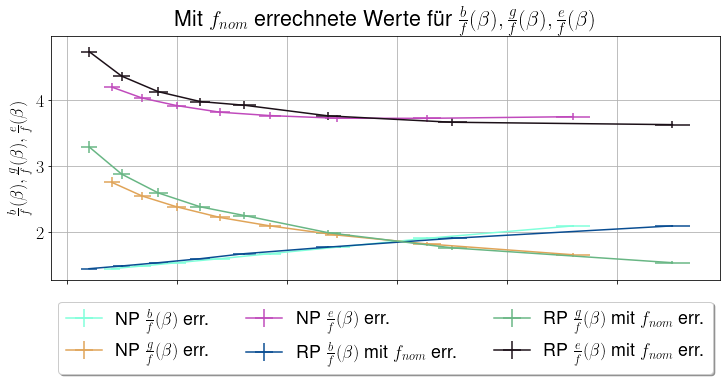

In [30]:
# Gemessene Werte Versuchteil 2
g_gem_2 = np.array([300,310,320,330,340,350,360,370]) - pos_dia  
e_gem_2_unv = np.array([432,426,427,430,435,440,446,452]) - pos_dia #Unvertauschte Linsen
e_gem_2_ver = np.array([450,431,425,424,430,435,440,445]) - pos_dia #Vertauschte Linsen

d_2, d_2_f = 20, 1

g_gem_2_f, e_gem_2_f = 1, 2
b_gem_2_f = np.sqrt(e_gem_2_f**2+g_gem_2_f**2)

b_gem_2_unv = e_gem_2_unv-g_gem_2
b_gem_2_ver = e_gem_2_ver-g_gem_2

f_gem_2_unv = g_gem_2*b_gem_2_unv/(g_gem_2+b_gem_2_unv)
f_fem_2_ver = g_gem_2*b_gem_2_ver/(g_gem_2+b_gem_2_ver)

#BETAS

beta_gem_2_unv = b_gem_2_unv/g_gem_2
beta_gem_2_unv_f = (1/g_gem_2)*(np.sqrt((e_gem_2_f**2)+((e_gem_2_unv/g_gem_2)**2)*(g_gem_2_f**2)))

beta_gem_2_ver = b_gem_2_ver/g_gem_2
beta_gem_2_ver_f = (1/g_gem_2)*(np.sqrt((e_gem_2_f**2)+((e_gem_2_ver/g_gem_2)**2)*(g_gem_2_f**2)))

# F LINSENSYSTEM

f_1, f_2 = 80, 150
f_nom_2 = ((1/(f_1))+(1/(f_2)))**(-1)#-d_2/(f_1+f_2)**(-1)

print(f_nom_2)
# NOMINELLE DATEN

bf_nom_2_unv = (1-(f_nom_2/g_gem_2))**(-1)
gf_nom_2_unv = (1-(f_nom_2/b_gem_2_unv))**(-1) 
ef_nom_2_unv = (((1/f_nom_2)-(1/g_gem_2))**(-1)+((1/f_nom_2)-(1/b_gem_2_unv))**(-1))/(f_nom_2)

bf_nom_2_unv_f = bf_nom_2_unv*(g_gem_2_f/g_gem_2)
gf_nom_2_unv_f = gf_nom_2_unv*(b_gem_2_f/b_gem_2_unv)
ef_nom_2_unv_f = ef_nom_2_unv*(am([(b_gem_2_f/b_gem_2_unv), (g_gem_2_f/g_gem_2)]))

bf_nom_2_ver = (1-(f_nom_2/g_gem_2))**(-1)
gf_nom_2_ver = (1-(f_nom_2/b_gem_2_ver))**(-1) 
ef_nom_2_ver = (((1/f_nom_2)-(1/g_gem_2))**(-1)+((1/f_nom_2)-(1/b_gem_2_ver))**(-1))/(f_nom_2)

bf_nom_2_ver_f = bf_nom_2_ver*(g_gem_2_f/g_gem_2)
gf_nom_2_ver_f = gf_nom_2_ver*(b_gem_2_f/b_gem_2_ver)
ef_nom_2_ver_f = ef_nom_2_ver*(am([(b_gem_2_f/b_gem_2_ver), (g_gem_2_f/g_gem_2)]))

#
# PLOTS
# GEMESSENEN WERTE

fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,5))
ax0.tick_params(axis='both', which='major', labelsize=18)
ax0.tick_params(axis='both', which='minor', labelsize=16)
ax0.set_xticklabels([])


# NORMALE LINSEN
ax0.errorbar(beta_gem_2_unv, bf_nom_2_unv, xerr=beta_gem_2_unv_f, yerr=bf_nom_2_unv_f, 
             color='#80ffdb', label=r'NP $\frac{b}{f}(\beta)$ err.')
ax0.errorbar(beta_gem_2_unv, gf_nom_2_unv, xerr=beta_gem_2_unv_f, yerr=gf_nom_2_unv_f, 
             color='#E0A458', label=r'NP $\frac{g}{f}(\beta)$ err.')
ax0.errorbar(beta_gem_2_unv, ef_nom_2_unv, xerr=beta_gem_2_unv_f, yerr=ef_nom_2_unv_f, 
             color='#C04ABC', label=r'NP $\frac{e}{f}(\beta)$ err.')

# VERDREHTE LINSEN

ax0.errorbar(beta_gem_2_ver, bf_nom_2_ver, xerr=beta_gem_2_ver_f, yerr=bf_nom_2_ver_f, 
             color='#094D92', label=r'RP $\frac{b}{f}(\beta)$ mit $f_{nom}$ err.')
ax0.errorbar(beta_gem_2_ver, gf_nom_2_ver, xerr=beta_gem_2_ver_f, yerr=gf_nom_2_ver_f, 
             color='#68B684', label=r'RP $\frac{g}{f}(\beta)$ mit $f_{nom}$ err.')
ax0.errorbar(beta_gem_2_ver, ef_nom_2_ver, xerr=beta_gem_2_ver_f, yerr=ef_nom_2_ver_f, 
             color='#1C1018', label=r'RP $\frac{e}{f}(\beta)$ mit $f_{nom}$ err.')


ax0.set(xlabel=r'', ylabel=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$', 
       title=r'Mit $f_{nom}$ errechnete Werte für $\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
# Shrink current axis's height by 10% on the bottom
box = ax0.get_position()
ax0.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)

ax0.grid()

fig.savefig("VT2Vergleich1.svg")

b_gem_2 = (b_gem_2_unv+b_gem_2_ver)/2
e_gem_2 = (e_gem_2_unv+e_gem_2_ver)/2

f_gem_2 = am((g_gem_2/((e_gem_2_unv+e_gem_2_ver)/2))*(((e_gem_2_unv+e_gem_2_ver)/2)-g_gem_2))
f_gem_2_f = am(np.sqrt((((g_gem_2-b_gem_2)**2)/(e_gem_2**2))*(e_gem_2_f**2)+(((g_gem_2/e_gem_2)**4)*(b_gem_2_f**2))+((b_gem_2/e_gem_2)**4)*(g_gem_2_f**2)))
phi_gem_2 = 1/f_gem_2
phi_gem_2_f = phi_gem_2*(f_gem_2_f/f_gem_2)
print('f gemessen, fehler',f_gem_2, f_gem_2_f)
print('phi gemessen, fehler', phi_gem_2, phi_gem_2_f)

In [ ]:
# Gemessene Werte Versuchteil 3
g_gem_3 = np.array([400,410,420,430,440,450,460,470])  - pos_dia 
g_gem_3_f = 0.5

e_gem_3_unv = np.array([732,704,685,674,667,665,664,653]) - pos_dia #Unvertauschte Linsen
e_gem_3_ver = np.array([662,661,663,669,673,679,681]) - pos_dia #Vertauschte Linsen
e_gem_3_f = 2

Bg_gem_3_unv = np.array([15,12,11,10,8,8,7,6])
Bg_gem_3_ver = np.array([8,7,6,6,6,5,5,5])
Bg_gem_3_f = 1

b_gem_3_unv = e_gem_3_unv - g_gem_3
b_gem_3_unv_f = np.sqrt(e_gem_3_f**2+g_gem_3_f**2)
b_gem_3_ver = e_gem_3_ver - g_gem_3
b_gem_3_ver_f = np.sqrt(e_gem_3_f**2+g_gem_3_f**2)

#BETAS

beta_gem_3_unv = b_gem_3_unv/g_gem_3
beta_gem_3_unv_f = (1/g_gem_3)*(np.sqrt((e_gem_3_f**2)+((e_gem_3_unv/g_gem_3)**2)*(g_gem_3_f**2)))

beta_gem_3_ver = b_gem_3_ver/g_gem_3
beta_gem_3_ver_f = (1/g_gem_3)*(np.sqrt((e_gem_3_f**2)+((e_gem_3_ver/g_gem_3)**2)*(g_gem_3_f**2)))

# Brennweiten

f_3_1, f_3_2 = 150, -200
f_nom_3 = ((1/(f_1))+(1/(f_2)))**(-1)#-d_2/(f_1+f_2)**(-1)



In [14]:
# Gemessene Werte Versuchteil 4
f_4 = 250
f_gem_4_blau = 438-pos_dia
f_gem_4_blau_f = 2
f_gem_4_rot = 446-pos_dia
f_gem_4_rot_f = 2

nue = am([f_gem_4_blau,f_gem_4_rot])/(f_gem_4_rot-f_gem_4_blau)
nue_f = 2

print(am([f_gem_4_blau,f_gem_4_rot]))
print(nue)
print(1/nue)

242.0
30.25
0.03305785123966942


In [ ]:
#g, b, f = symbols('g b f')
#func = ((1/b)+(1/g))**(-1)
#print(f_gem_1)
#for i in range(len(b_gem_1)):
#    print(fehler(func, np.array([g_gem_1[i], b_gem_1[i]]), np.array([5, 5]), np.array([g, b])))

#fig.savefig("AbhängigkeitBeta.png")


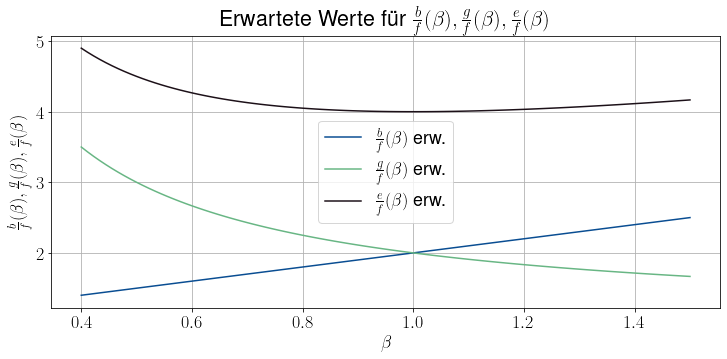

In [23]:
# ERWARTETE WERTE
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,5))
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=16)

beta_rech = np.linspace(0.4, 1.5, 100)
gf_rech = 1+beta_rech**(-1)
bf_rech = beta_rech +1
ef_rech = 2+ beta_rech+ beta_rech**(-1)

ax1.plot(beta_rech, bf_rech, color='#094D92', label=r'$\frac{b}{f}(\beta)$ erw.')
ax1.plot(beta_rech, gf_rech, color='#68B684', label=r'$\frac{g}{f}(\beta)$ erw.')
ax1.plot(beta_rech, ef_rech, color='#1C1018', label=r'$\frac{e}{f}(\beta)$ erw.')

ax1.set(xlabel=r'$\beta$', ylabel=r'$\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$', 
       title=r'Erwartete Werte für $\frac{b}{f}(\beta), \frac{g}{f}(\beta), \frac{e}{f}(\beta)$')
ax1.legend()
ax1.grid()
fig.savefig("VT2Vergleich2.svg")